# Day 3: Symbolic Distillation of PINNs

Welcome to the final stage of our journey! 

## The Goal
We have successfully trained a **Physics-Informed Neural Network (PINN)** to solve a Partial Differential Equation (PDE). However, the neural network is a "black box" — it gives us the right numbers, but not the mathematical understanding.

**Our Mission**: Use **Symbolic Regression** to extracting the analytical law $u(x, t)$ directly from the trained neural network.

## The Process
1. **Train a PINN**: We will re-train a PINN on the Heat Equation: $u_t = \alpha u_{xx}$.
2. **The Oracle**: Use the trained PINN as an "Oracle" to generate clean, high-resolution data.
3. **Distillation**: Use `PySR` to find the symbolic equation that best fits the PINN's output.
4. **Discovery**: Recover the analytical solution: $u(x, t) = \sin(\pi x)e^{-\alpha \pi^2 t}$.

## 1. Setup and Dependencies
We need `torch` for the PINN and `pysr` for symbolic regression.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from pysr import PySRRegressor

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Using device: cpu


## 2. Train the PINN (The Teacher)

We solved the Heat Equation in Day 2. Let's quickly re-implement it here to have a fresh model.

**Problem**: 
$$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$$
with $\alpha = 0.01$, and initial condition $u(x, 0) = \sin(\pi x)$.

In [2]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple MLP: 2 inputs (x, t) -> 1 output (u)
        self.net = nn.Sequential(
            nn.Linear(2, 32), nn.Tanh(), nn.Linear(32, 32), nn.Tanh(), nn.Linear(32, 1)
        )

    def forward(self, x, t):
        # Concatenate x and t to form a (N, 2) input
        inputs = torch.cat([x, t], dim=1)
        return self.net(inputs)


def compute_pde_residual(model, x, t, alpha=0.01):
    x.requires_grad = True
    t.requires_grad = True
    u = model(x, t)

    # Gradients
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[
        0
    ]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[
        0
    ]
    u_xx = torch.autograd.grad(
        u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True
    )[0]

    return u_t - alpha * u_xx


# True solution for comparison
def true_solution(x, t, alpha=0.01):
    return np.sin(np.pi * x) * np.exp(-alpha * np.pi**2 * t)

### Training Loop

In [3]:
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
alpha = 0.01
iterations = 5000

print("Training PINN...")
for i in range(iterations):
    optimizer.zero_grad()

    # 1. Collocation points for PDE
    x_pde = torch.rand(2000, 1).to(device)  # x in [0, 1]
    t_pde = torch.rand(2000, 1).to(device)  # t in [0, 1]
    res = compute_pde_residual(model, x_pde, t_pde, alpha)
    loss_pde = torch.mean(res**2)

    # 2. Initial Condition (t=0)
    x_ic = torch.rand(500, 1).to(device)
    t_ic = torch.zeros(500, 1).to(device)
    u_ic_pred = model(x_ic, t_ic)
    u_ic_true = torch.sin(np.pi * x_ic)
    loss_ic = torch.mean((u_ic_pred - u_ic_true) ** 2)

    # 3. Boundary Conditions (x=0, x=1)
    t_bc = torch.rand(500, 1).to(device)
    x_bc0 = torch.zeros(500, 1).to(device)
    x_bc1 = torch.ones(500, 1).to(device)
    u_bc0 = model(x_bc0, t_bc)
    u_bc1 = model(x_bc1, t_bc)
    loss_bc = torch.mean(u_bc0**2) + torch.mean(u_bc1**2)

    loss = loss_pde + loss_ic + loss_bc
    loss.backward()
    optimizer.step()

    if i % 1000 == 0:
        print(f"Iter {i}, Loss: {loss.item():.5f}")

print("Training Complete.")

Training PINN...
Iter 0, Loss: 0.82733
Iter 1000, Loss: 0.00057
Iter 2000, Loss: 0.00005
Iter 3000, Loss: 0.00002
Iter 4000, Loss: 0.00001
Training Complete.


## 3. The Oracle: Data Distillation

Now that we have a trained model, we will use it to generate a high-quality dataset. 
This dataset is cleaner than real-world data and allows symbolic regression to work efficiently.

In [4]:
# Generate a grid of points
x_vals = np.linspace(0, 1, 50)
t_vals = np.linspace(0, 1, 50)
X_grid, T_grid = np.meshgrid(x_vals, t_vals)

X_flat = X_grid.flatten()[:, None]
T_flat = T_grid.flatten()[:, None]

x_tensor = torch.tensor(X_flat, dtype=torch.float32).to(device)
t_tensor = torch.tensor(T_flat, dtype=torch.float32).to(device)

# Ask the Oracle (PINN) for the solution
model.eval()
with torch.no_grad():
    u_pred = model(x_tensor, t_tensor).cpu().numpy()

# Prepare data for PySR
# Input: [x, t]
# Output: u
X_sr = np.hstack([X_flat, T_flat])
y_sr = u_pred.flatten()

print(f"Distilled Dataset Shape: {X_sr.shape} -> {y_sr.shape}")

Distilled Dataset Shape: (2500, 2) -> (2500,)


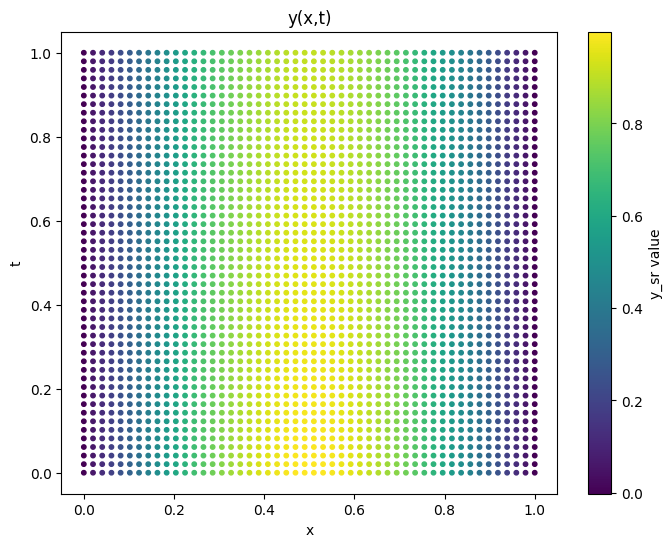

In [5]:
import matplotlib.pyplot as plt

# create a colormap with x,t and y
import numpy as np

plt.figure(figsize=(8, 6))


scatter = plt.scatter(X_sr[:, 0], X_sr[:, 1], c=y_sr, cmap="viridis", s=10)
plt.colorbar(scatter, label="y_sr value")
plt.xlabel("x")
plt.ylabel("t")
plt.title("y(x,t)")
plt.show()

## 4. Symbolic Regression with PySR

We will now feed this data into `PySRRegressor`. 
We give it a hint by providing the unary operators `sin` and `exp`, as we suspect the solution might involve waves or decay.

In [6]:
model_sr = PySRRegressor(
    niterations=100,
    binary_operators=["+", "*", "-", "/"],
    unary_operators=[
        "sin",  # Expected in spatial part
        "exp",  # Expected in temporal part
        # "cos",  # Optional, let's see if it picks it up
    ],
    variable_names=["x", "t"],
    verbosity=1,
)

print("Starting Symbolic Regression... might take a minute...")
model_sr.fit(X_sr, y_sr)

/Users/pedrolugao/Documents/PeruClasses/.venv/lib/python3.12/site-packages/pysr/sr.py:1046: FutureWarning: `variable_names` is a data-dependent parameter and should be passed when fit is called. Ignoring parameter; please pass `variable_names` during the call to fit instead.
  warnings.warn(
/Users/pedrolugao/Documents/PeruClasses/.venv/lib/python3.12/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...


Starting Symbolic Regression... might take a minute...


[ Info: Started!



Expressions evaluated per second: 2.500e+04
Progress: 153 / 3100 total iterations (4.935%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           9.193e-02  0.000e+00  y = 0.59287
4           1.478e-03  1.377e+00  y = sin(x₀ * 3.1622)
6           4.997e-04  5.422e-01  y = sin(3.1622 * x₀) / 1.0367
10          3.781e-04  6.967e-02  y = sin(((x₀ + x₀) * 1.0716) + x₀) * 0.95112
12          3.780e-04  1.519e-04  y = sin(((x₀ + x₀) * 1.0716) + (x₀ - 0.00049893)) * 0.9511...
                                      2
18          3.780e-04  9.934e-08  y = sin(x₀ + (((x₀ + ((x₀ * 1.1432) - 0.00026576)) - (x₀ -...
                                       x₀)) - 0.00026621)) * 0.95113
───────────────────────────────────────────────────────────────────────────────────────────────────
═══════════════════

[ Info: Final population:
[ Info: Results saved to:


,model_selection,'best'
,binary_operators,"['+', '*', ...]"
,unary_operators,"['sin', 'exp']"
,expression_spec,None
,niterations,100
,populations,31
,population_size,27
,max_evals,None
,maxsize,30
,maxdepth,None
,warmup_maxsize_by,None


Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [7]:
model_sr.latex(0)

'0.593'

Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

## 5. Analysis and "Verification"

Let's look at the best equation found.

In [8]:
print("Best equation:")
print(model_sr.sympy())

print("\nTarget Analytical Equation:")
print(f"sin(pi * x) * exp(-{alpha * np.pi**2:.4f} * t)")
print(f"approx: sin(3.1415*x) * exp(-0.0987*t)")

Best equation:
(0.998159 + x1*(-0.09428466))*sin(x0*3.1424408)

Target Analytical Equation:
sin(pi * x) * exp(-0.0987 * t)
approx: sin(3.1415*x) * exp(-0.0987*t)
Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [9]:
# Verify accuracy
y_sym_pred = model_sr.predict(X_sr)
mse = np.mean((y_sym_pred - y_sr) ** 2)
print(f"MSE between Symbolic and PINN: {mse:.6e}")

MSE between Symbolic and PINN: 3.889278e-07
Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

## 6. Exercises

1. **Noisy Oracle**: Add Gaussian noise to `y_sr` before passing it to PySR. How robust is the symbolic regression?
2. **Different PDE**: Change the PINN to solve the Burgers' equation (from Day 1) and try to distill the shockwave equation.
3. **Missing Operators**: Remove "sin" from the unary_operators list. Can PySR approximate the sine wave using Taylor expansion terms (polynomials)?